In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from api_keys import gkey

## Work with number of rides for different weather data

In [4]:
# Read file with weather API output and create DataFrame
file = "Output/weather.csv"
df_weather = pd.read_csv(file)
df_weather[['Date', 'Time']] = df_weather['time'].str.split('T', n=1, expand=True)

# Count the total rides in our weather sample
totalrides = len(df_weather)-1

# Create weather groups and add colunn to DataFrame
di = {'clear-day':'Clear',
      'clear-night':'Clear', 
      'cloudy':'Cloudy', 
      'fog':'Cloudy', 
      'partly-cloudy-day':'Partly Cloudy', 
      'partly-cloudy-night':'Partly Cloudy'}                   

df_weather['Weather Group'] = df_weather['icon'].map(di).fillna(df_weather['icon'].str.capitalize())

df_weather.head()

,Unnamed: 0,Trip ID,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,windSpeed,icon,Date,Time,Weather Group
0,0,bc6f08423e9f194cb63a0d5ec6c6a2dea001e914,2013-11-16T01:45:00,Partly Cloudy,0.0000,0.00,43.39,40.05,5.59,partly-cloudy-night,2013-11-16,01:45:00,Partly Cloudy
1,1,b2e0ede2b0d907551beda4e8b4b83c143010f63d,2016-09-28T04:45:00,Overcast,0.0005,0.14,53.40,53.40,1.25,cloudy,2016-09-28,04:45:00,Cloudy
2,2,c2155aedc41a27673cd498d0fea754a18132d7f9,2013-12-10T07:15:00,Mostly Cloudy,0.0000,0.00,7.20,-4.92,7.53,partly-cloudy-day,2013-12-10,07:15:00,Partly Cloudy
3,3,c1e860354f05150021e1bdeb7696314ca3e15608,2014-02-27T09:00:00,Clear,0.0000,0.00,5.96,-5.93,7.04,clear-day,2014-02-27,09:00:00,Clear
4,4,bdff93a935333338e6f2f04f778ad7713a36c9ad,2016-10-31T04:15:00,Clear,0.0000,0.00,43.05,43.05,1.80,clear-night,2016-10-31,04:15:00,Clear


In [5]:
# Count rides per weather group and date
df_WeatherGrouped = df_weather.groupby(['Weather Group','Date'], as_index=False).agg({'Trip ID': 'count', 'precipIntensity': 'mean', 'precipProbability': 'mean', 'temperature': 'mean', 'apparentTemperature': 'mean', 'windSpeed': 'mean'})
df_WeatherGrouped = df_WeatherGrouped.rename(columns = {'Trip ID':'Ride Count'})
df_WeatherGrouped.head()

,Weather Group,Date,Ride Count,precipIntensity,precipProbability,temperature,apparentTemperature,windSpeed
0,Clear,2013-01-01,1,0.0,0.0,20.130000,20.130000,2.750000
1,Clear,2013-01-02,1,0.0,0.0,11.490000,11.490000,2.550000
2,Clear,2013-01-04,7,0.0,0.0,19.184286,10.281429,6.868571
3,Clear,2013-01-05,1,0.0,0.0,22.900000,22.900000,2.670000
4,Clear,2013-01-07,2,0.0,0.0,21.915000,15.160000,5.065000


In [6]:
# Calculate the average values on a daily basis for each Weather Group to normalize data
df_WeatherSummary = df_WeatherGrouped.groupby('Weather Group', as_index=False).mean()
df_WeatherSummary = df_WeatherSummary.rename(columns = {'Ride Count': 'Average Rides/Day'})

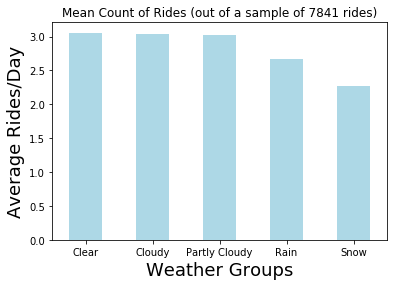

,Weather Group,Average Rides/Day,precipIntensity,precipProbability,temperature,apparentTemperature,windSpeed
0,Clear,3.056300,0.000015,0.002185,47.665360,46.343265,2.787437
1,Cloudy,3.036624,0.000273,0.034504,43.103433,40.722017,4.245144
2,Partly Cloudy,3.025717,0.000068,0.007913,52.070306,50.777698,3.603087
3,Rain,2.668224,0.031868,0.713307,55.006937,54.101942,3.935530
4,Snow,2.272727,0.006458,0.471470,33.017348,29.381561,4.864439


In [31]:
df_WeatherSummary.plot(kind='bar', y = 'Average Rides/Day', x = 'Weather Group', legend = False, rot = 0, color='lightblue',
                      title=f'Mean Count of Rides (out of a sample of {totalrides} rides)')
plt.ylabel('Average Rides/Day', fontsize=18)
plt.xlabel('Weather Groups', fontsize=18)

try: os.mkdir('Images')
except: pass
plt.savefig("Images/Rides-WeatherGroups.png")

plt.show()
df_WeatherSummary

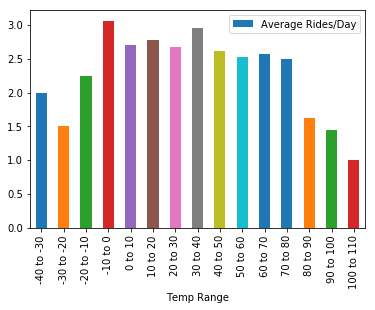

,Average Rides/Day
Temp Range,
-40 to -30,2.000000
-30 to -20,1.500000
-20 to -10,2.250000
-10 to 0,3.061224
0 to 10,2.696629
10 to 20,2.773256
20 to 30,2.671642
30 to 40,2.949405
40 to 50,2.607251


In [468]:
# Create Temperature bins in 10F increments including minimum and maximum temperatures observed
tbins = np.arange(int(min(df_weather['apparentTemperature'])/10-1)*10, 
                  int(max(df_weather['apparentTemperature'])/10+2)*10, 10)

# Create bin labels
tbin_names = [f"{tbins[i]} to {tbins[i+1]}" for i in range(len(tbins)-1)]
    
# Calculate average daily number of rides per temperature bin
df_TempRides = df_weather
df_TempRides['Temp Range'] = pd.cut(df_weather['apparentTemperature'], tbins, labels=tbin_names)
df_TempRides = df_TempRides.groupby(['Temp Range', 'Date'], as_index=False).agg({'Trip ID': 'count'})
df_TempRides = df_TempRides.groupby('Temp Range').mean()
df_TempRides = df_TempRides.rename(columns = {'Trip ID':'Average Rides/Day'})

# Create bar chart and save png file
df_TempRides.plot(kind='bar', y = 'Average Rides/Day')
try: os.mkdir('Images')
except: pass
plt.savefig("Images/Rides-Temp.png")

plt.show()
df_TempRides

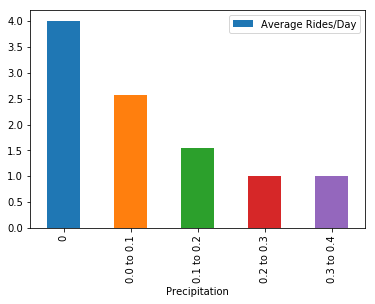

,Average Rides/Day
Precipitation,
0,4.007453
0.0 to 0.1,2.569767
0.1 to 0.2,1.538462
0.2 to 0.3,1.000000
0.3 to 0.4,1.000000


In [467]:
# create precipitation bins and labels
precipitation_bins = np.arange(int(min(df_weather['precipIntensity'])/0.1-1)*0.1, 
                               int(max(df_weather['precipIntensity'])/0.1+2)*0.1, 0.1)
pr_names = [f"{precipitation_bins[i]:.2} to {precipitation_bins[i+1]:.2}" for i in range(len(precipitation_bins)-1)]
pr_names[0]=0

# Calculate average daily number of rides per precipitation bin
df_PreRides = df_weather
df_PreRides['Precipitation'] = pd.cut(df_weather['precipIntensity'], precipitation_bins, labels=pr_names)
df_PreRides = df_PreRides.groupby(['Precipitation', 'Date'], as_index=False).agg({'Trip ID': 'count'})
df_PreRides = df_PreRides.groupby('Precipitation').mean()
df_PreRides = df_PreRides.rename(columns = {'Trip ID':'Average Rides/Day'})


# Create bar chart and save png file
df_PreRides.plot(kind='bar', y = 'Average Rides/Day')
try: os.mkdir('Images')
except: pass
plt.savefig("Images/Rides-Precipitation.png")

plt.show()
df_PreRides

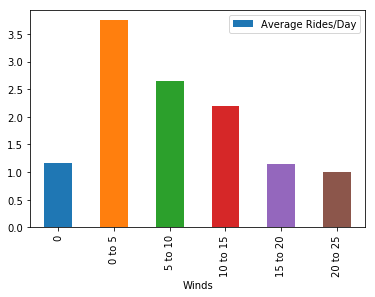

,Average Rides/Day
Winds,
0,1.166667
0 to 5,3.747754
5 to 10,2.639876
10 to 15,2.191489
15 to 20,1.142857
20 to 25,1.000000


In [466]:
# create wind bins and labels
wind_bins = np.arange(int(min(df_weather['windSpeed'])/5-1)*5, 
                      int(max(df_weather['windSpeed'])/5+2)*5, 5)

wind_names = [f"{wind_bins[i]} to {wind_bins[i+1]}" for i in range(len(wind_bins)-1)]
wind_names[0] = 0
    
# Calculate average daily number of rides per wind bin
df_WindRides = df_weather
df_WindRides['Winds'] = pd.cut(df_weather['windSpeed'], wind_bins, labels=wind_names)
df_WindRides = df_WindRides.groupby(['Winds', 'Date'], as_index=False).agg({'Trip ID': 'count'})
df_WindRides = df_WindRides.groupby('Winds').mean()
df_WindRides = df_WindRides.rename(columns = {'Trip ID':'Average Rides/Day'})

# Create bar chart and save png file
df_WindRides.plot(kind='bar', y = 'Average Rides/Day')
try: os.mkdir('Images')
except: pass
plt.savefig("Images/Rides-Wind.png")

plt.show()
df_WindRides

## Create Heat Maps based on number of rides and temperature information